Making black-box binary face classifier with SIFT/keypoints feature extraction and KNN/SVM classifier

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-faces/Humans/1 (2916).jpg
/kaggle/input/human-faces/Humans/1 (607).jpg
/kaggle/input/human-faces/Humans/1 (3767).jpg
/kaggle/input/human-faces/Humans/1 (576).jpg
/kaggle/input/human-faces/Humans/1 (1856).jpg
/kaggle/input/human-faces/Humans/1 (1464).jpg
/kaggle/input/human-faces/Humans/1 (1290).jpg
/kaggle/input/human-faces/Humans/1 (1341).jpg
/kaggle/input/human-faces/Humans/1 (2598).jpg
/kaggle/input/human-faces/Humans/1 (789).jpg
/kaggle/input/human-faces/Humans/1 (882).jpg
/kaggle/input/human-faces/Humans/1 (5469).jpg
/kaggle/input/human-faces/Humans/1 (6466).jpg
/kaggle/input/human-faces/Humans/1 (6835).jpg
/kaggle/input/human-faces/Humans/1 (6027).jpg
/kaggle/input/human-faces/Humans/1 (4288).jpg
/kaggle/input/human-faces/Humans/1 (550).jpg
/kaggle/input/human-faces/Humans/1 (509).jpg
/kaggle/input/human-faces/Humans/1 (2135).jpg
/kaggle/input/human-faces/Humans/1 (3690).jpg
/kaggle/input/human-faces/Humans/1 (3664).jpg
/kaggle/input/human-faces/Humans/1 (6160

https://www.kaggle.com/datasets/ashwingupta3012/human-faces

In [8]:
!pip install MTCNN --user # MTCNN library
!pip install pycocotools --user # Remove the tf warning for mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.5 MB/s eta 0:00:00a 0:00:01


In [29]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import distance
from mtcnn.mtcnn import MTCNN
from PIL import Image

from matplotlib.patches import Circle

In [5]:
# Kill the regular warnings and tensorFlow warnings:
import warnings
warnings.filterwarnings(action='ignore')
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
def M_distance(u,v):
  iv = [[1, 0.5], [0.5, 1]]
  return distance.mahalanobis(list(u), list(v), iv)

In [26]:
# Here will be a feature extractor for the faces from images.
def extract_face_from_image(image_path, required_size=(224, 224)):
    # load image and detect faces
    image = plt.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)

    #This is just a debug print:
    for face in faces:    
      print(face['keypoints'])
      print(f"The Mahalanobis distance is :{round(M_distance(face['keypoints']['left_eye'],face['keypoints']['right_eye']),2)}")

    face_images = []

    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        x2, y2 = x1 + width, y1 + height

        # extract the face
        face_boundary = image[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = np.asarray(face_image)
        face_images.append({'image':face_array,'keypoints':face['keypoints'],'box':face['box']})

    return face_images

In [3]:
path='../input/human-faces'

def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endswith('png'):
                images.append(filename)
    return images

images=images_upload(path)

0it [00:00, ?it/s]
100%|██████████| 7219/7219 [00:00<00:00, 1075122.70it/s]


In [28]:
extracted_face = extract_face_from_image(images[0])

{'left_eye': (193, 179), 'right_eye': (276, 208), 'nose': (201, 248), 'mouth_left': (162, 265), 'mouth_right': (241, 292)}
The Mahalanobis distance is :100.68


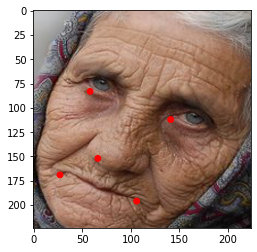

In [61]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

plt.imshow(extracted_face[0]['image'])

x1, y1, width, height = extracted_face[0]['box']
keypoint_values = list(extracted_face[0]['keypoints'].values())
keypoint_values = [((value[0]-x1),(value[1]-y1)) for value in keypoint_values]

for xx,yy in keypoint_values:
    circ = Circle((xx,yy),3, color='Red')
    ax.add_patch(circ)

plt.show()

In [65]:
# create SIFT feature extractor
sift = cv2.SIFT_create()

# detect features from the image
keypoints, descriptors = sift.detectAndCompute(extracted_face[0]['image'], None)

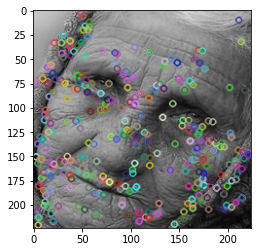

In [69]:
# draw the detected key points
gray = cv2.cvtColor(extracted_face[0]['image'], cv2.COLOR_BGR2GRAY)
sift_image = cv2.drawKeypoints(gray, keypoints, extracted_face[0]['image'])
# show the image
plt.imshow(sift_image)